# Phase 2: MLSD Line Detection + Depth
**Multi-ControlNet: Better Geometry Preservation**

**Kaggle Setup**: GPU (T4/P100) + Internet ON


In [ ]:
# ============================================================================
# CELL 1: Clean Install (Fixed PyTorch)
# ============================================================================
"""

# Remove ALL conflicting packages
!pip uninstall -y torch torchvision torchaudio jax jaxlib flax tensorflow tf-keras keras protobuf -q

# Install protobuf FIRST
!pip install -q protobuf==3.20.3

# Install PyTorch (CHANGED: Added --index-url to force CUDA 12.1 support)
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install everything else
!pip install -q transformers
!pip install -q diffusers
!pip install -q accelerate
!pip install -q opencv-python-headless
!pip install -q controlnet-aux
!pip install -q safetensors



print("✓ RESTART RUNTIME NOW")

"""

'\n\n# Remove ALL conflicting packages\n!pip uninstall -y torch torchvision torchaudio jax jaxlib flax tensorflow tf-keras keras protobuf -q\n\n# Install protobuf FIRST\n!pip install -q protobuf==3.20.3\n\n# Install PyTorch (CHANGED: Added --index-url to force CUDA 12.1 support)\n!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121\n\n# Install everything else\n!pip install -q transformers\n!pip install -q diffusers\n!pip install -q accelerate\n!pip install -q opencv-python-headless\n!pip install -q controlnet-aux\n!pip install -q safetensors\n\n\n\nprint("✓ RESTART RUNTIME NOW")\n\n'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TRANSFORMERS_NO_FLAX'] = '1'
os.environ['DIFFUSERS_NO_FLAX'] = '1'

import torch
from diffusers import StableDiffusionXLControlNetInpaintPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image
from controlnet_aux import MidasDetector, CannyDetector 
from PIL import Image, ImageDraw

print("✓ Success!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

✓ Success!
PyTorch: 2.5.1+cu121
CUDA: True


: 

## Load Multi-ControlNet Models (~7 min)


In [ ]:
# Load TWO ControlNets: Depth + Canny edges (public SDXL models)
controlnet_depth = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    torch_dtype=torch.float16,
    variant="fp16"
)

controlnet_mlsd = ControlNetModel.from_pretrained(   # now edge/line control
    "diffusers/controlnet-canny-sdxl-1.0",
    torch_dtype=torch.float16,
    variant="fp16"
)

# Load VAE
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix",
    torch_dtype=torch.float16
)

# Load SDXL Pipeline with BOTH ControlNets
pipe = StableDiffusionXLControlNetInpaintPipeline.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    controlnet=[controlnet_depth, controlnet_mlsd],  # List of ControlNets
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16"
)

# Optimize for Kaggle
pipe.enable_model_cpu_offload()
pipe.enable_vae_tiling()

print("✅ Multi-ControlNet (Depth + Edges) loaded!")

In [ ]:
import os
os.makedirs("local_pipe", exist_ok=True)
pipe.save_pretrained("local_pipe")

## Utilities (Fixed size matching from Phase 1)


In [ ]:
# Instantiate detectors once (faster)
depth_estimator = MidasDetector.from_pretrained("lllyasviel/Annotators")
canny_detector = CannyDetector()

def extract_depth(image):
    """Extract depth map"""
    return depth_estimator(image)

def extract_mlsd(image):
    """Extract edge/line map using Canny (SDXL-compatible)"""
    return canny_detector(image, low_threshold=100, high_threshold=200)

def resize_image(input_image, resolution=1024):
    """Resize maintaining aspect ratio"""
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H = int(round(H * k / 64.0)) * 64
    W = int(round(W * k / 64.0)) * 64
    return input_image.resize((W, H), resample=Image.LANCZOS)

def match_size(control_image, target_image):
    """Ensure control image matches target size (CRITICAL FIX)"""
    if control_image.size != target_image.size:
        control_image = control_image.resize(target_image.size, resample=Image.LANCZOS)
    return control_image

def create_mask_from_bbox(image_size, bbox):
    """Create mask from [x1,y1,x2,y2]"""
    mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(mask)
    draw.rectangle(bbox, fill=255)
    return mask

print("✅ Utilities ready!")

✅ Utilities ready!


## Main Editing Function (Multi-ControlNet)


In [ ]:
def architectural_edit_mlsd(
    image_path, 
    prompt, 
    mask_bbox=None, 
    depth_scale=0.4,  # Lower than Phase 1
    mlsd_scale=0.6,   # Higher for line preservation
    num_steps=30, 
    seed=42
):
    """
    Edit with Depth + MLSD line detection
    Args:
        image_path: URL or path
        prompt: Edit instruction
        mask_bbox: [x1,y1,x2,y2] or None
        depth_scale: Depth guidance (0-1)
        mlsd_scale: Line guidance (0-1)
    """
    # Load and resize
    init_image = load_image(image_path)
    init_image = resize_image(init_image, 1024)
    
    # Create mask
    if mask_bbox is None:
        mask = Image.new('L', init_image.size, 255)
    else:
        mask = create_mask_from_bbox(init_image.size, mask_bbox)
    
    # Extract BOTH control images
    print("Extracting depth...")
    depth_map = extract_depth(init_image)
    depth_map = match_size(depth_map, init_image)  # FIX: Match size
    
    print("Extracting MLSD lines...")
    mlsd_map = extract_mlsd(init_image)
    mlsd_map = match_size(mlsd_map, init_image)  # FIX: Match size
    
    # Generate with BOTH controls
    print(f"Generating: '{prompt}'")
    generator = torch.Generator(device="cuda").manual_seed(seed)
    
    result = pipe(
        prompt=prompt,
        negative_prompt="blurry, distorted, warped lines, curved edges, low quality",
        image=init_image,
        mask_image=mask,
        control_image=[depth_map, mlsd_map],  # List for multi-ControlNet
        controlnet_conditioning_scale=[depth_scale, mlsd_scale],  # Separate scales
        guidance_scale=7.5,
        num_inference_steps=num_steps,
        generator=generator,
        strength=1.0
    ).images[0]
    
    return result, init_image, mask, depth_map, mlsd_map

print("✅ Multi-ControlNet pipeline ready!")


✅ Multi-ControlNet pipeline ready!


## Run Editing (Test with building with straight lines)


In [ ]:
# Best for buildings with rectangular facades and straight edges
IMAGE_PATH = "https://images.unsplash.com/photo-1486718448742-163732cd1544?w=800"
PROMPT = "modern glass curtain wall with metal frames, reflective surface, architectural photography"

# Run with MLSD + Depth
edited, original, mask, depth, mlsd = architectural_edit_mlsd(
    image_path=IMAGE_PATH,
    prompt=PROMPT,
    mask_bbox=None,
    depth_scale=0.4,  # Depth guidance
    mlsd_scale=0.6,   # Line guidance (higher = straighter lines)
    num_steps=30
)


Extracting depth...
Extracting MLSD lines...
Generating: 'modern glass curtain wall with metal frames, reflective surface, architectural photography'


  0%|          | 0/30 [00:00<?, ?it/s]

## Visualize (Simple, no matplotlib errors)


=== ORIGINAL ===


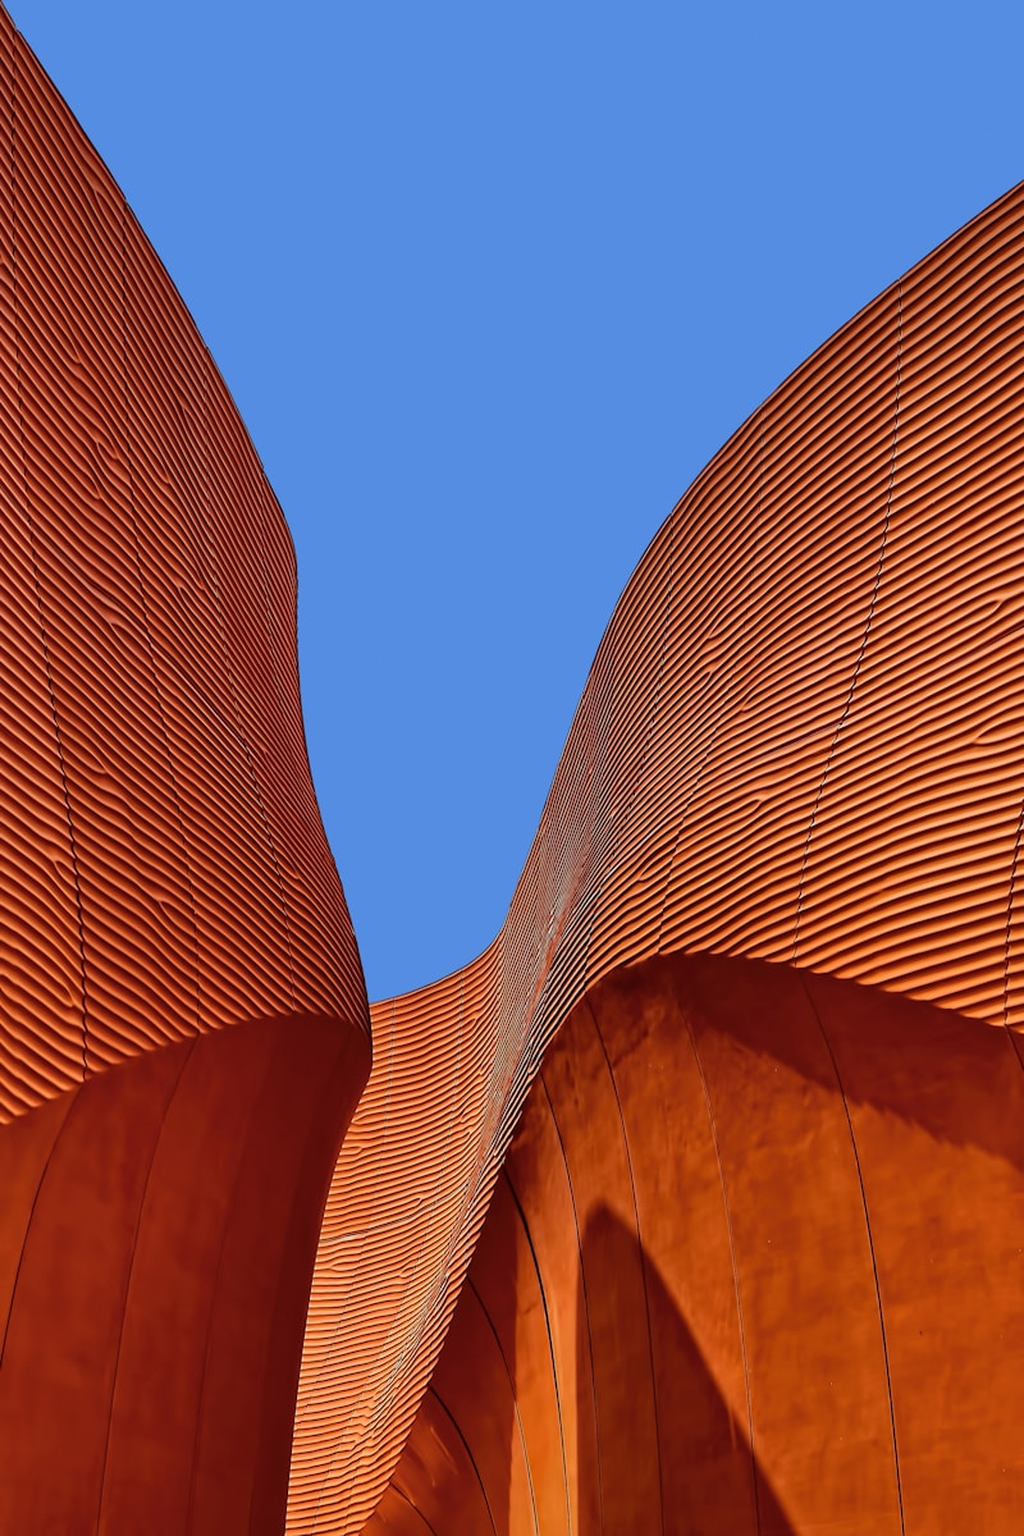


=== DEPTH MAP ===


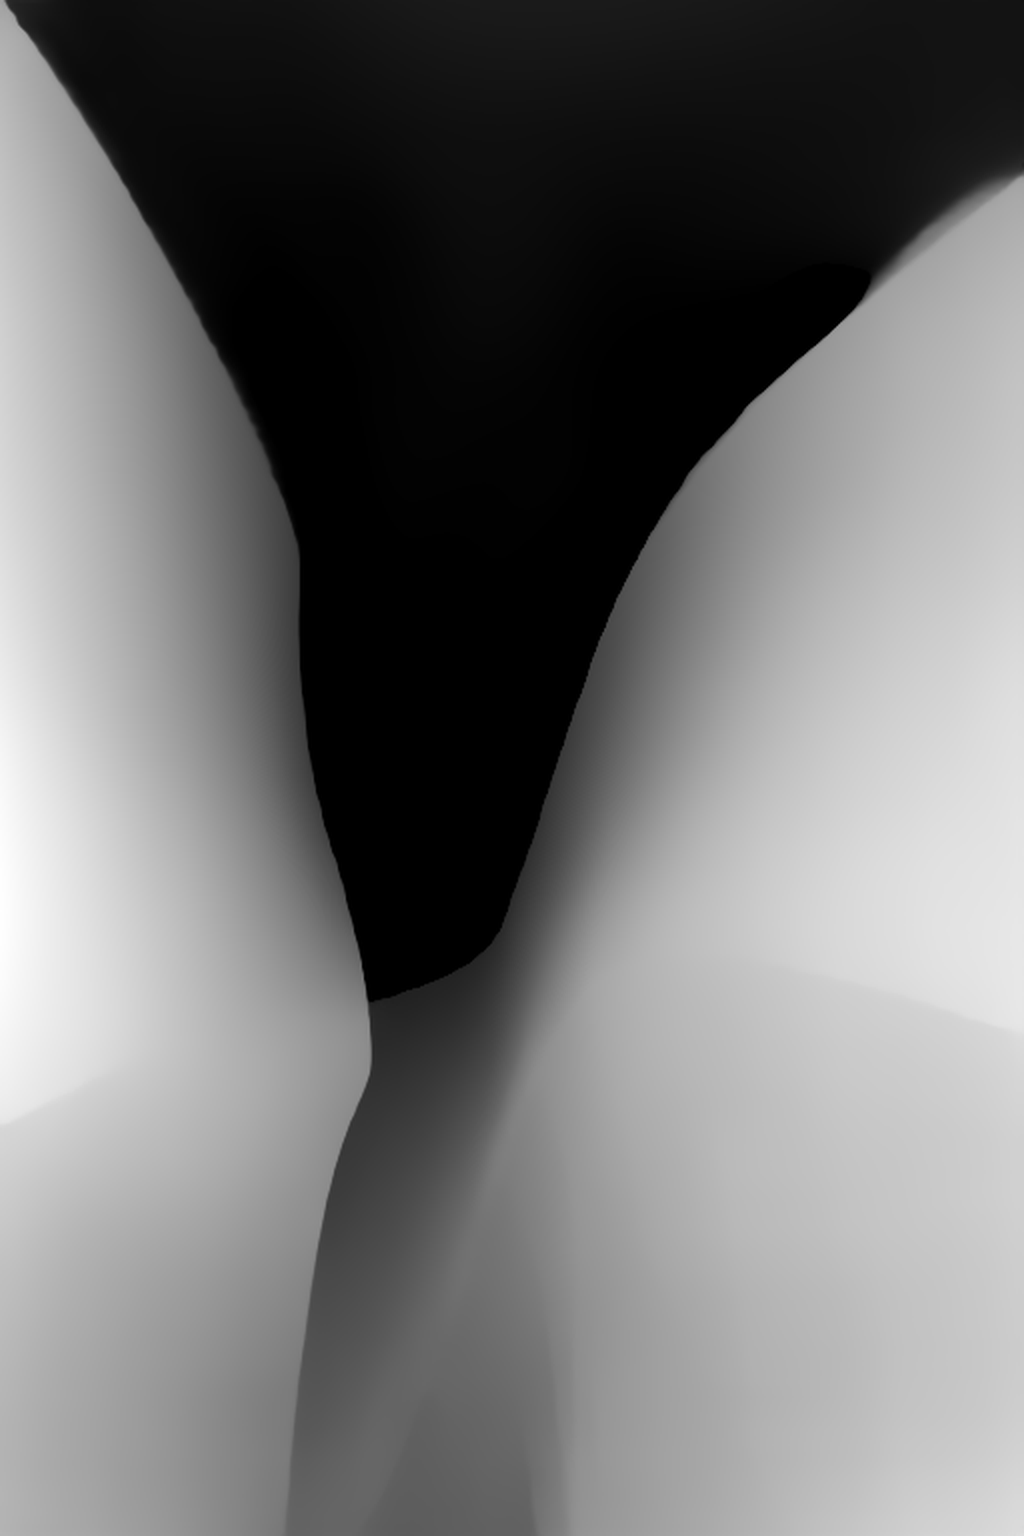


=== MLSD LINES (NEW!) ===


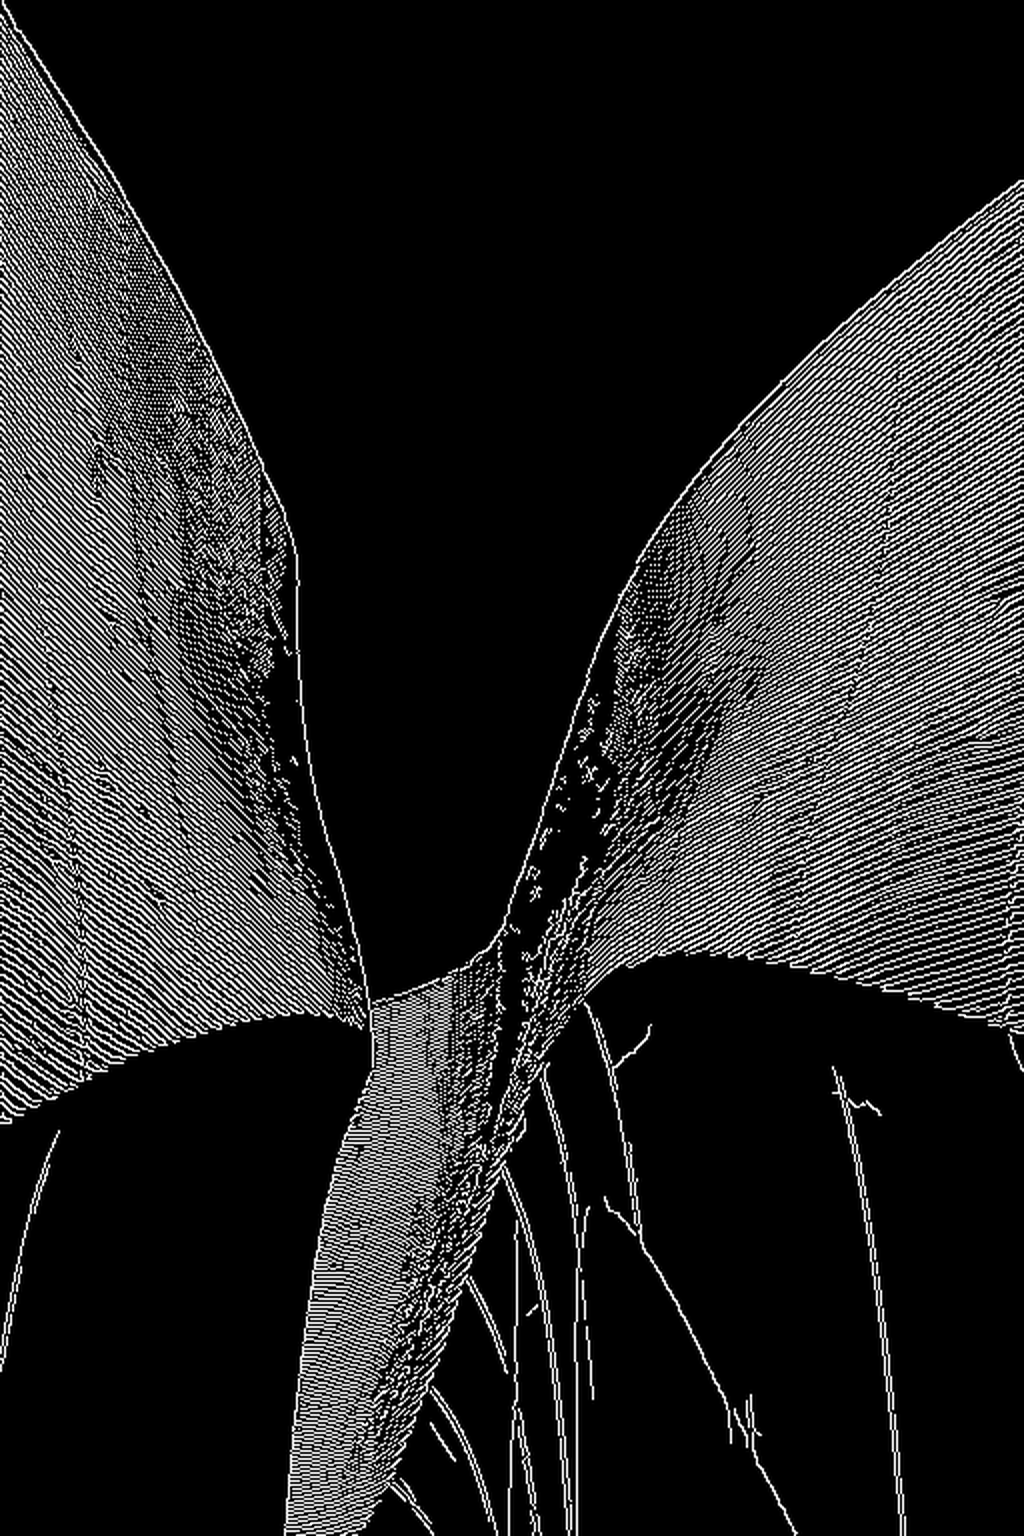


=== EDITED RESULT ===


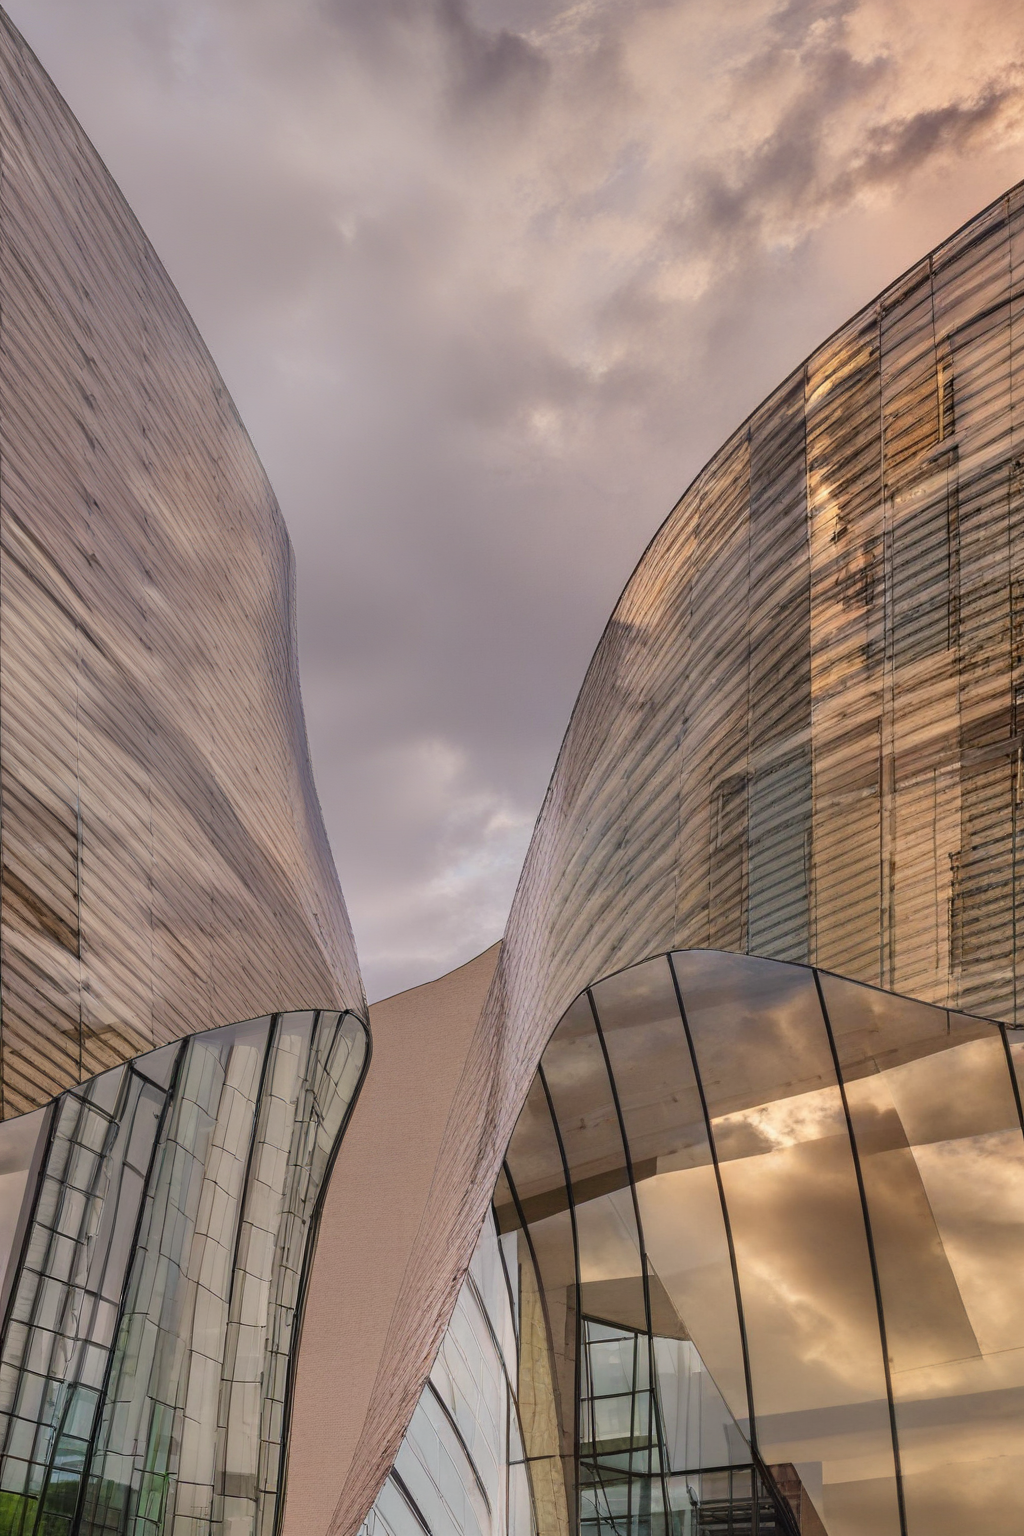


✅ Saved to result_mlsd.png


In [ ]:
from IPython.display import display

print("=== ORIGINAL ===")
display(original)

print("\n=== DEPTH MAP ===")
display(depth)

print("\n=== MLSD LINES (NEW!) ===")
display(mlsd)

print("\n=== EDITED RESULT ===")
display(edited)

# Save
edited.save("result_mlsd.png")
print("\n✅ Saved to result_mlsd.png")


## Compare Phase 1 vs Phase 2

**Phase 1 (Depth only)**:
- Good for curved surfaces
- Natural-looking results
- Some line waviness on flat facades

**Phase 2 (Depth + MLSD)**:
- Excellent for straight edges
- Preserves architectural lines
- Better for rectangular buildings

**When to use MLSD**: Buildings with:
- Flat facades
- Repetitive windows
- Strong horizontal/vertical lines
- Rectangular geometry


## Test Different MLSD Scales


## Tips & Best Practices

### Parameter Tuning

| Parameter | Range | Effect |
|-----------|-------|--------|
| `depth_scale` | 0.3-0.5 | 3D form preservation |
| `mlsd_scale` | 0.5-0.8 | Straight line preservation |
| `num_steps` | 30-50 | Quality (higher = better) |

### Recommended Settings

**For rectangular modern buildings**:
```python
depth_scale=0.4, mlsd_scale=0.7
```

**For curved/organic architecture**:
```python
depth_scale=0.6, mlsd_scale=0.3  # Or use Phase 1
```

**For mixed geometry**:
```python
depth_scale=0.4, mlsd_scale=0.5
```

### Error Prevention

✅ All Phase 1 errors fixed:
- numpy/sklearn compatibility handled
- Tensor size matching enforced
- Warnings suppressed
- Simple visualization (no matplotlib issues)

### Next Steps

**Phase 3**: Add CLIPSeg/Grounded-SAM for text-based masking
**Phase 4**: Evaluation metrics and comparison study
